In [1]:
# Import libraries
import glob
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

from imblearn.over_sampling import SMOTE 
from matplotlib import pyplot as plt
from scipy.stats import bootstrap
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

# Avoid warnings
warnings.filterwarnings('ignore')  

# 1. Time Series Classification Part 1: Feature Creation/Extraction
An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

## (a) Download the AReM data
from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+(AReM) 

The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which con- tains 6 time series and each time series has 480 consecutive values.

I notice that dataset4.csv in bending2 folder is not the standard form of a csv file. I format that file by replacing space with comma in Sublime Text. Additioanlly, there are additional comma for `dataset9.csv` and `dataset14.csv` in the cycling folder. I manually remove them according to [this post](https://piazza.com/class/l7149q4oxue34e/post/455) on Piazza.

## (b)
Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [2]:
# Define a function to split testing and training data within a folder
def data_split(FolderName, num_data_set, num_test_set):
    # Make testing dataset
    test_set = list()
    for i in range(1, num_test_set+1):
        path = '../data/ARem/' + FolderName + '/dataset' + str(i) + '.csv'
        df_test = pd.read_csv(path, skiprows = 4)  # Skip first 4 rows of information
        # Label bending
        if (FolderName == "bending1") or (FolderName == "bending2"):
            df_test["bending_label"] = 1
        else:
            df_test["bending_label"] = 0
        test_set.append(df_test)
    test_frame = pd.concat(test_set, ignore_index=True)
    
    # Make trainig dataset
    train_set = list()
    for j in range(num_test_set+1, num_data_set+1):
        path = '../data/ARem/' + FolderName + '/dataset' + str(j) + '.csv'
        df_train = pd.read_csv(path, skiprows = 4)  # Skip first 4 rows of information
        # Label bending
        if (FolderName == "bending1") or (FolderName == "bending2"):
            df_train["bending_label"] = 1
        else:
            df_train["bending_label"] = 0
        train_set.append(df_train)
    train_frame = pd.concat(train_set, ignore_index=True)
    
    return test_frame, train_frame


In [3]:
# Generate testing and training data from ARem folder
# Initialize list to store information
arem_testing = list()
arem_training = list()

# Deal with bending data first
bending = ["bending1", "bending2"]
arem_testing.append(data_split("bending1", 7, 2)[0])
arem_training.append(data_split("bending1", 7, 2)[1])
arem_testing.append(data_split("bending2", 6, 2)[0])
arem_training.append(data_split("bending2", 6, 2)[1])
    
# Deal with other data
other = ["cycling", "lying", "sitting", "standing", "walking"]
for folder in other:
    arem_testing.append(data_split(folder, 15, 3)[0])
    arem_training.append(data_split(folder, 15, 3)[1])
      
# Concatenate into testing and training dataframe
AREM_test = pd.concat(arem_testing, ignore_index=True)
AREM_train = pd.concat(arem_training, ignore_index=True)

In [4]:
# Check the dimensions
print("Testing set shape:", AREM_test.shape)
print("Training set shape:", AREM_train.shape)

Testing set shape: (9120, 8)
Training set shape: (33119, 8)


## (c) Feature Extraction
Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

### i. 
Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

According to the information [here](https://stats.stackexchange.com/questions/50807/features-for-time-series-classification#:~:text=Usually%20the%20features%20used%20to,than%20being%20features%20in%20themselves.), the following features can be used in the time series classification.

**Statistical features**
1. Mean
2. Standard devition
3. Skewness, Kurtosis
4. Maximum and Minimum values

**Time series features**
1. Cross-Correlations between each dimension and the Auto-Correlations
2. Orders of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model
3. Parameters of the AR part
3. Parameters of the MA part

### ii.
Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [5]:
# Define a function to extract time-domain features for 6 time series in each instance
# Features: minimum, maximum, mean, median, standard deviation, first quartile, and third quartile
# Add bending_label = 1 for bending, bending_label = 0 for other activities
# Add testing_label = 1 for testing data, testing_label = 0 for training data

def feature_extraction(FolderName, num_csv, num_test):
    # Define path to locate csv files
    train_csv = list()
    test_csv = list()
    
    # Format testing and training file path
    for i in range(1, num_test+1):
        path = '../data/ARem/' + FolderName + "/dataset" + str(i) +".csv"
        test_csv.append(path)
    for i in range(num_test+1, num_csv+1):
        path = '../data/ARem/' + FolderName + "/dataset" + str(i) +".csv"
        train_csv.append(path)
    
    # Set up variable to count number of instance
    global instance_cnt
    # Store extracted features
    extraction = list()
    
    # Iterate through testing csv files and read as dataframe
    for filename in train_csv:
        df = pd.read_csv(filename, skiprows=4)
        temp = [instance_cnt]
        # Extract information from each dataframe
        for series_name in series:
            # Extract feature information 
            for feature in features:
                temp.append(df.describe()[series_name][feature])
        
        # Include label indicating bending or not 
        if (FolderName == "bending1") or (FolderName == "bending2"):
            temp.append(1)
        else:
            temp.append(0)
        
        # Include label for traning
        temp.append(0)
                
        extraction.append(temp)
        instance_cnt += 1
    
    # Iterate through training csv files and read as dataframe
    for filename in test_csv:
        df = pd.read_csv(filename, skiprows=4)
        temp = [instance_cnt]
        # Extract information from each dataframe
        for series_name in series:
            # Extract feature information 
            for feature in features:
                temp.append(df.describe()[series_name][feature])
        
        # Include label indicating bending or not 
        if (FolderName == "bending1") or (FolderName == "bending2"):
            temp.append(1)
        else:
            temp.append(0)
        
        # Include label for testing
        temp.append(1)
                
        extraction.append(temp)
        instance_cnt += 1
    
    return extraction


In [6]:
# Set serie names
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series_formatname = [i for i in range(1, 7)]
# Set feature names to be extracted
features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
features_formatname = ['min', 'max', 'mean', 'median', 'std dev', '1st quart', '3rd quart']

# Initialize counting and list to store information
instance_cnt = 1
extracted_features = list()

# Iterate through csv in bending1 folder
extracted_features.extend(feature_extraction("bending1", 7, 2))
# Iterate through csv in bending1 folder
extracted_features.extend(feature_extraction("bending2", 6, 2))
# Iterate through other folders in ARem
for folder_name in other:
    extracted_features.extend(feature_extraction(folder_name, 15, 3))

In [7]:
# Format column names for table
col = ['Instance']
for series_name in series_formatname:
    for feature in features_formatname:
        col.append(feature + "_" + str(series_name))

col.append("bending_label")
col.append("testing_label")

# Convert extracted information into dataframe
df_feature = pd.DataFrame(extracted_features, columns=col)
# display(df_feature)

### iii.
Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python's bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [8]:
# Drop the instnace and bending label since they are trivial for this part
df_feature_est = df_feature.loc[:, ~df_feature.columns.isin(["Instance", "bending_label", "testing_label"])]
col_est = col[1:-3]

# Estimate the standard deviation for each feature
df_std = df_feature_est.std()
display(df_std)

min_1          9.569975
max_1          4.394362
mean_1         5.335718
median_1       5.440054
std dev_1      1.772153
1st quart_1    6.153590
3rd quart_1    5.138925
min_2          0.000000
max_2          5.062729
mean_2         1.574164
median_2       1.412244
std dev_2      0.884105
1st quart_2    0.946386
3rd quart_2    2.125266
min_3          2.956462
max_3          4.875137
mean_3         4.008380
median_3       4.036396
std dev_3      0.946710
1st quart_3    4.220658
3rd quart_3    4.171628
min_4          0.000000
max_4          2.183625
mean_4         1.166114
median_4       1.145586
std dev_4      0.458242
1st quart_4    0.843620
3rd quart_4    1.552504
min_5          6.124001
max_5          5.741238
mean_5         5.675593
median_5       5.813782
std dev_5      1.024898
1st quart_5    6.096465
3rd quart_5    5.531720
min_6          0.045838
max_6          2.518921
mean_6         1.154812
median_6       1.086474
std dev_6      0.517617
1st quart_6    0.758584
3rd quart_6    1

The standard deviation of each of the time-domain features we extracted are list above. We can observe that features like mean, median, and the stand deviation have relatively low standard deviation.

Let's implement the bootstrap on featurs we extracted.

In [9]:
# Fill nan value
df_feature_fill = df_feature_est.fillna(0)

# After formatting dataset4 of bending2, we don't need to fill NaN value
df_feature_fill = df_feature_est 

# Convert to sequence
data = (df_feature_fill, )
# Calculate 90% bootstrap confidence interval
res = bootstrap(data, np.std, confidence_level=0.9, method='basic')
# Store result
CI = list()
for i in range(0, len(col_est)):
    CI.append([col_est[i], res.confidence_interval[0][i], res.confidence_interval[1][i]])
    
# Display result
df_CI = pd.DataFrame(CI, columns=["Feature", "Lower bound", "Upper bound"])
display(df_CI)

,Feature,Lower bound,Upper bound
0,min_1,8.318579,10.810984
1,max_1,3.496054,5.438132
2,mean_1,4.766753,5.930568
3,median_1,4.859483,6.052125
4,std dev_1,1.587404,1.966031
5,1st quart_1,5.630884,6.691605
6,3rd quart_1,4.413510,5.902514
7,min_2,0.000000,0.000000
8,max_2,4.685568,5.467953
9,mean_2,1.433179,1.740122


It seems like displaying the table is a little bit hard for us to decide important features that we should pick. We will then plot the confidence interval to assist us.

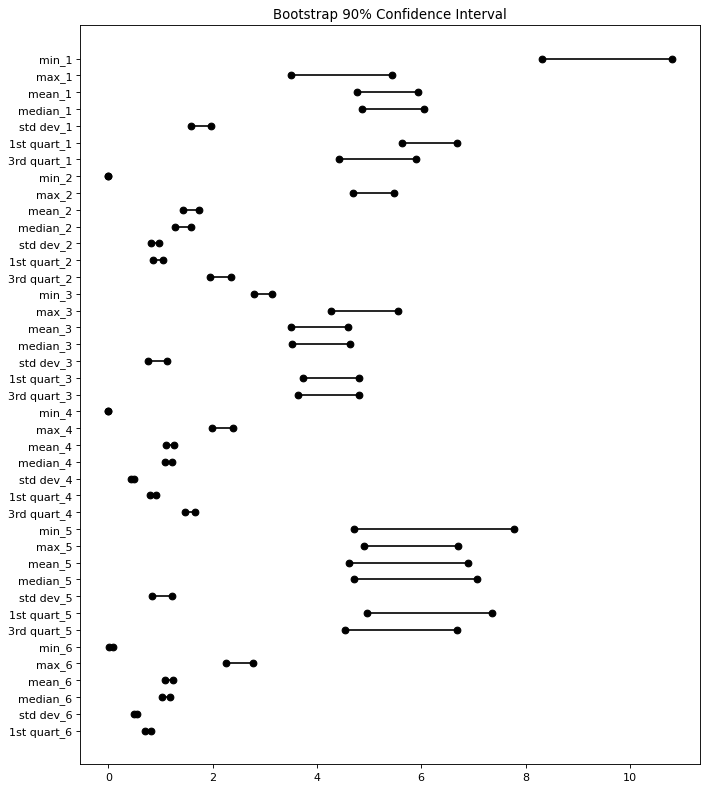

In [10]:
# Plot confidence interval result
plt.figure(figsize=(10, 12), dpi=80)
for i in range(0, len(col_est)):
    plt.plot((res.confidence_interval[0][i], res.confidence_interval[1][i]),
             (i, i),
             'o-',
             color='black')
plt.title("Bootstrap 90% Confidence Interval")
plt.yticks(range(0, len(col_est)), col_est)
plt.gca().invert_yaxis()
plt.show()

### iv.
Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

I would like to choose mean, median, and standard deviation to be the tree most important time-domain features. 

From the graph above, observe that we see the feature standard deviation in general is having small value of estimated values even when other features are having large confidence interval or estimated value. Moreover, we see that mean and median features are having smaller confidence interval when comparing to others. This means that choosing mean and median would be more accurate for our classificatio model.

Notice that even the feature min has small value of confidence intervals, we are not picking min feature here because we see that some of the 90% confidence interval of min is $(0, 0)$, so do the estimated standard deviation of min. We want to include more flexibility in our classification model. Thus, we are not picking feature min here.

**Homework 4 begins here**

# 2. Time Series Classification Part 2: Binary and Multiclass Classification

## (a) Binary Classification Using Logistic Regression

### i.
Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in **1(c)iv** extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p.129 of the textbook).

In [11]:
# Get training data from dataframe
df_feature_train = df_feature.loc[df_feature["testing_label"] == 0]
print(df_feature_train.shape)

(69, 45)


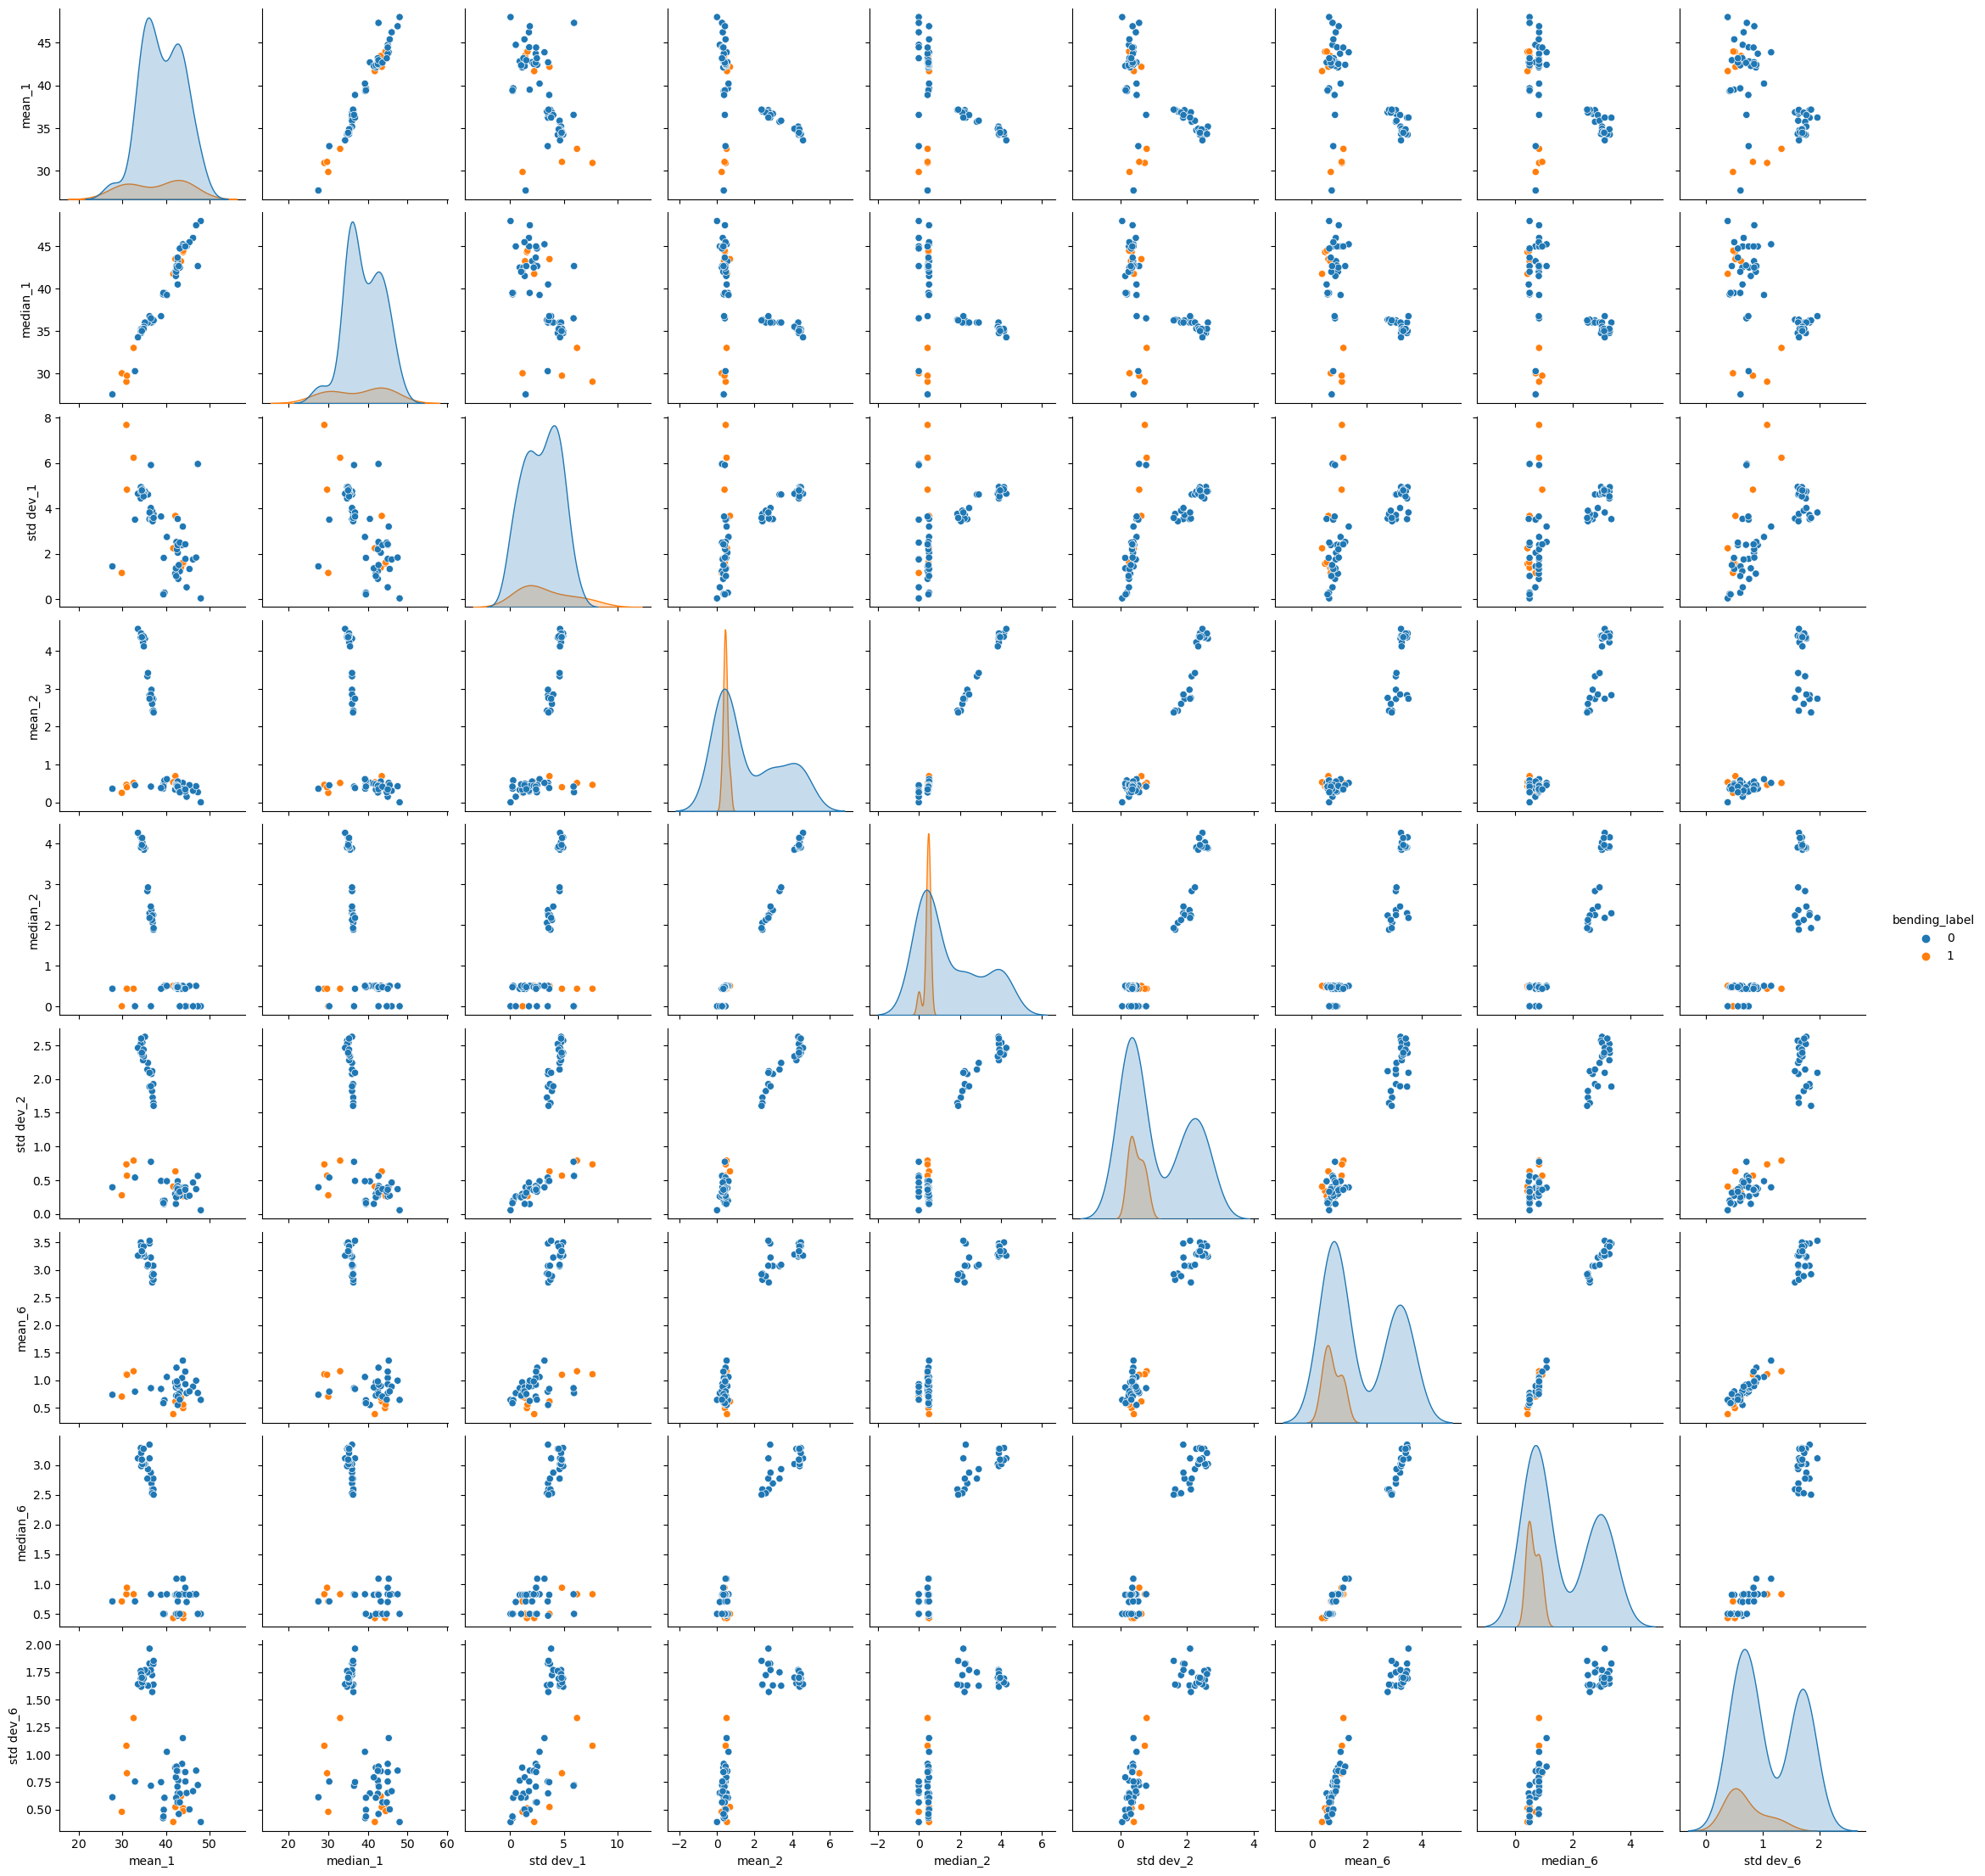

In [12]:
# Define series we are interested in
series_names = [1, 2, 6]
# Define features we are interested in
features_formatname = ['mean', 'median', 'std dev']

# Format column names we are interested in
col_sub = []
for series_name in series_names:
    for feature in features_formatname:
        col_sub.append(feature + "_" + str(series_name))
col_sub.append("bending_label")

# Extract data for scatter plot
df_feature_126 = df_feature_train[col_sub]

# Plot pair plots
sns.pairplot(df_feature_126, hue="bending_label")
plt.show()

I modify code from Homework 3 to include a column `bending_label` to assist us distinguish between bending and other activities. We can see that `bending_label=1` means the bending activity, and we label 0 otherwise. 

Addtionally, I also include the column `testing_label` to assist us whether an instance belongs to the training set or testing set. We label `testing_label=1` as such an instance is in the testing data, and we label `testing_label=0` for training data.

### ii.
Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in **2(a)i**, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of **2(a)i**?

In [13]:
# Select first half of dataframe
df_first_half = df_feature_126[0:math.floor(len(df_feature_train)/2)]
# Rest index and clean dataframe
df_first_half = df_first_half.reset_index()
df_first_half = df_first_half.iloc[:, 1:]
# display(df_first_half)

# Rename the columns
col_rename = {}
for series_name in series_names:
    for feature in features_formatname:
        col_rename[feature + "_" + str(series_name)] = (feature + "_" + str(series_name) + "_1")
col_rename["bending_label"] = "bending_label"

# Rename the first half
df_first_half = df_first_half.rename(columns=col_rename)
# display(df_first_half)

In [14]:
# Select second half of dataframe
df_second_half = df_feature_126[math.floor(len(df_feature_train)/2):-1]
# Rest index and clean dataframe
df_second_half = df_second_half.reset_index()
df_second_half = df_second_half.iloc[:, 1:-1]
# display(df_second_half)

# Rename the second half
col_rename = {}
for series_name in series_names:
    for feature in features_formatname:
        col_rename[feature + "_" + str(series_name)] = (feature + "_" + str(series_name) + "_2")
# print(col_rename)
df_second_half = df_second_half.rename(columns=col_rename)
# display(df_second_half)

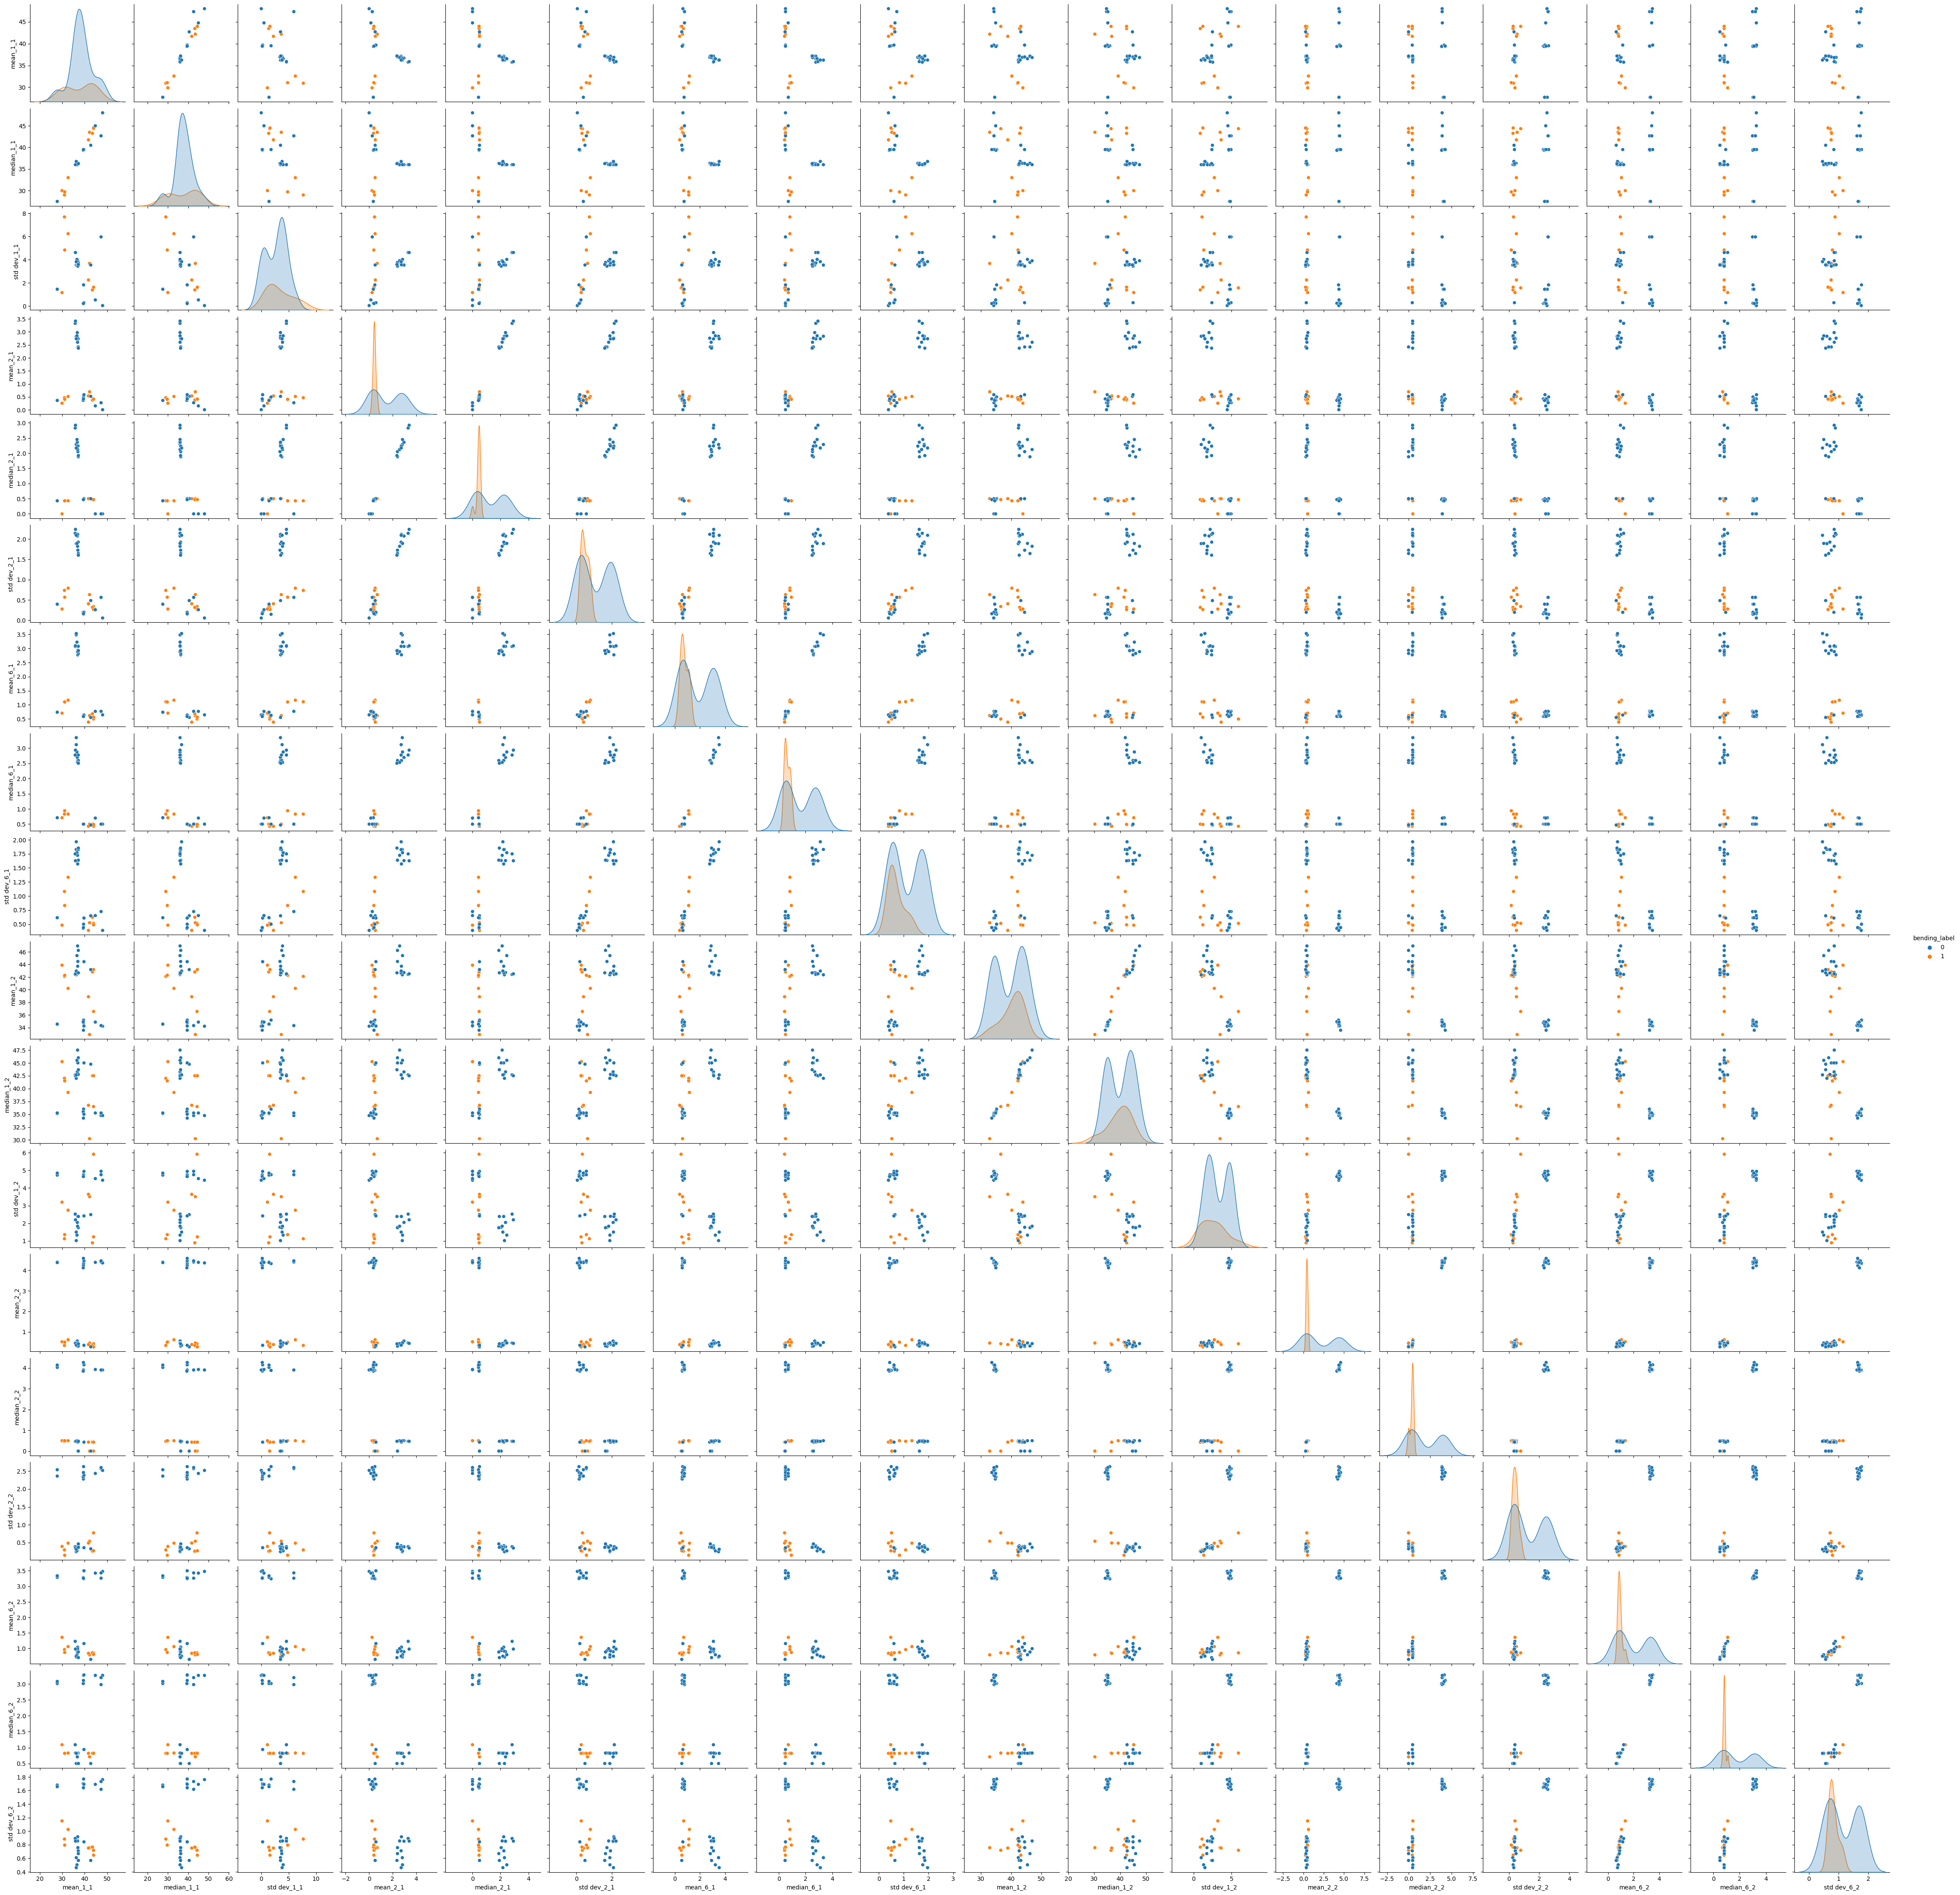

In [15]:
# Concatenate into new dataframe
df_break_feature = pd.concat([df_first_half, df_second_half], axis=1)
# display(df_break_feature)

# Plot pair plots
sns.pairplot(df_break_feature, hue="bending_label")
plt.show()

To compare the result we obtained from **2.(a)i**, we see that when we devide each time series in the training set into two approximately equal sets, we see a much clear pattern for classification. From the plot above, we can see some boundary between bending and other activities, while we find it hard to distinguish them in **2.(a)i**.

### iii.
Break each time series in your training set into $l \in \{1, 2, \dots, 20\}$ time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of $l$ and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using `sklearn.feature selection` or `glm` in R. Use 5-fold cross-validation to determine the best value of the pair $(l, p)$, where $p$ is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use *stratified cross validation*. Research what it means and use it if needed.

In the following, you can see an example of applying Python's Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression.

```
Recursive Feature Elimination code
...
```

In [16]:
# Modify the function defined in HW3 to extract 3 time-domain features for 6 series in each instance
# Note that we also add L=number of partition to split the data
# Features: mean, median, and standard deviation
# bending_label = 1 for bending, bending_label = 0 for other activities
# testing_label = 1 for testing data, testing_label = 0 for training data

def important_feature_extraction(FolderName, num_csv, num_test, l):
    # Define path to locate csv files
    train_csv = list()
    test_csv = list()

    # Format training and testing file path
    for i in range(1, num_test+1):
        path = '../data/ARem/' + FolderName + "/dataset" + str(i) +".csv"
        test_csv.append(path)
    for i in range(num_test+1, num_csv+1):
        path = '../data/ARem/' + FolderName + "/dataset" + str(i) +".csv"
        train_csv.append(path)

    feature_extraction = list()  # Hold statistics for all file we read
    # Read testing csv file into dataframe
    for filename in test_csv:
        df = pd.read_csv(filename, names=csv_header, skiprows=5)
        df = df.drop("time", axis=1)  # Drop time column

        # Split dataframe into sub dataframe according to L = number of partition
        # df_split is a list of sub dataframe
        df_split = np.array_split(df, l)

        split_info = list()  # Initialize a list to hold information for the single dataframe, i.e. csv

        # For each sub dataframe, find mean, median, and std dev
        for df_sub in df_split:
            sub_df_info = list()  # Initialize a list to hold information for each sub dataframe
            for series_name in series:
                for feature in features:
                    # Obtain statistics in the order of mean, median and std dev
                    sub_df_info.append(df_sub.describe()[series_name][feature])

            split_info.extend(sub_df_info)  # Add dataframe into info list

        # Include label indicating bending or not 
        if (FolderName == "bending1") or (FolderName == "bending2"):
            split_info.append(str(1))
        else:
            split_info.append(str(0))

        # Include label for testing
        split_info.append(str(1))

        # Concatenate statistics for all splits 
        df_concat_info = pd.DataFrame(split_info).transpose()
        feature_extraction.append(df_concat_info)
        
    # Read training csv file into dataframe
    for filename in train_csv:
        df = pd.read_csv(filename, names=csv_header, skiprows=5)
        df = df.drop("time", axis=1)  # Drop time column

        # Split dataframe into sub dataframe according to L = number of partition
        # df_split is a list of sub dataframe
        df_split = np.array_split(df, l)

        split_info = list()  # Initialize a list to hold information for the single dataframe, i.e. csv

        # For each sub dataframe, find mean, median, and std dev
        for df_sub in df_split:
            sub_df_info = list()  # Initialize a list to hold information for each sub dataframe
            for series_name in series:
                for feature in features:
                    # Obtain statistics in the order of mean, median and std dev
                    sub_df_info.append(df_sub.describe()[series_name][feature])

            split_info.extend(sub_df_info)  # Add dataframe into info list

        # Include label indicating bending or not 
        if (FolderName == "bending1") or (FolderName == "bending2"):
            split_info.append(1)
        else:
            split_info.append(0)

        # Include label for training
        split_info.append(0)

        # Concatenate statistics for all splits 
        df_concat_info = pd.DataFrame(split_info).transpose()
        feature_extraction.append(df_concat_info)
    
    return feature_extraction

In [17]:
# Define some information
csv_header = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series_formatname = [i for i in range(1, 7)]

# Set feature names to be extracted
features = ['mean', '50%', 'std']
features_formatname = ['mean', 'median', 'std dev']

In [18]:
# Define the size of time series in training set
TimeSeries_size = [i for i in range(1, 21)]

# Save Logistics model evaluation result
plist = list()
score = list()

# Iterate through all size and train Logistics model
for l in TimeSeries_size:
    # Format column names
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    # Add bending_label and testing_label to column names
    column_name.extend(["bending_label", "testing_label"])
    
    important_feature = list()
    # Iterate through bending1 folder
    important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
    # Iterate through bending2 folder
    important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
    # Iterate through other folders in ARem
    for folder_name in other:
        important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))
        
    # Make dataframe for all information extracted
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    # Set column name accordingly
    df_important_feature.columns = column_name
    # Convert to numeric values
    # df_important_feature = df_important_feature.apply(pd.to_numeric)
    df_important_feature["bending_label"] = df_important_feature["bending_label"].astype('int')

    # Get training data
    df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:,-2:-1]
    
    # Fit Logistic Regression model
    model = LogisticRegression()
    # Fit RFECV model using RFE and 5-fold stratified cross-validation
    rfecv = RFECV(estimator = model, cv=StratifiedKFold(5), scoring = 'accuracy')
    rfecv.fit(X_train, Y_train) 
    
    # Report progress
    print("Optimal number of features for l =", l, "is", "%d" % rfecv.n_features_)
    print("Cross-validation score:", np.max(rfecv.cv_results_['mean_test_score']))
    
    plist.append(rfecv.n_features_)  # Record eliminated features
    score.append(np.max(rfecv.cv_results_['mean_test_score']))  # Record the max CV score found in each iteration

Optimal number of features for l = 1 is 6
Cross-validation score: 0.9560439560439562
Optimal number of features for l = 2 is 10
Cross-validation score: 0.9417582417582417
Optimal number of features for l = 3 is 38
Cross-validation score: 0.9714285714285715
Optimal number of features for l = 4 is 48
Cross-validation score: 0.9560439560439562
Optimal number of features for l = 5 is 87
Cross-validation score: 0.9703296703296704
Optimal number of features for l = 6 is 1
Cross-validation score: 0.9571428571428573
Optimal number of features for l = 7 is 75
Cross-validation score: 0.9571428571428573
Optimal number of features for l = 8 is 64
Cross-validation score: 0.9560439560439562
Optimal number of features for l = 9 is 9
Cross-validation score: 0.9571428571428573
Optimal number of features for l = 10 is 10
Cross-validation score: 0.9714285714285715
Optimal number of features for l = 11 is 156
Cross-validation score: 0.9714285714285715
Optimal number of features for l = 12 is 124
Cross-val

In [19]:
# Display best (l, p) pair along with p-value
df_bestp = pd.DataFrame({"l": TimeSeries_size, "p-features": plist, "Score":score})
df_bestp.index = np.arange(1, 21)
# Sort dataframe based on CV-score and l
df_bestp = df_bestp.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

 l  p-features    Score
13         182 0.985714
15         235 0.985714
20          67 0.985714
 3          38 0.971429
10          10 0.971429
11         156 0.971429
12         124 0.971429
14           1 0.971429
16           7 0.971429
17         193 0.971429
18         136 0.971429
19         214 0.971429
 5          87 0.970330
 6           1 0.957143
 7          75 0.957143
 9           9 0.957143
 1           6 0.956044
 4          48 0.956044
 8          64 0.956044
 2          10 0.941758


We sort the dataframe first by CV-score in descending order. We see there are multiple $(l, p)$ pairs that share same CV-score. Thus, we then sort by the $l$ column by descending order. This means that we want to find a smaller $l$ withe the CV-score is the same. Therefore, We found that the best $(l, p)$ pair is $(13, 182)$.

The wrong way to cross validation in this part is to apply cross validation and test a set of different parameters, to see which one gives us the lowest error rate. However, we should hold out a validation set or do nested cross validation to see how well the selected model performs.

We will use the $(l, p) = (10, 10)$ for the following problem given that in each run, we obtain a different $(l, p)$ pair.

### iv.
Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression $\beta_i$'s as well as the p-values associated with them.

In [24]:
# Show confusion matrix

l = 10
# Format column names
column_name = list()
for i in range(1, l+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(feature+"_"+str(series_name)+"_"+ str(i))
# Add bending_label and testing_label to column names
column_name.extend(["bending_label", "testing_label"])

important_feature = list()
# Iterate through bending1 folder
important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
# Iterate through bending2 folder
important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
# Iterate through other folders in ARem
for folder_name in other:
    important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))

# Make dataframe for all information extracted
df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
# Set column name accordingly
df_important_feature.columns = column_name
# Convert to numeric values
df_important_feature = df_important_feature.apply(pd.to_numeric)
df_important_feature["bending_label"] = df_important_feature["bending_label"].astype('int')

# Get training data
df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

# Define model input
X_train = df_LR_train.iloc[:, :-2]
Y_train = df_LR_train.iloc[:,-2:-1]

In [25]:
# Declare Logistic Regression model
model_train = LogisticRegression(solver='liblinear')
# Train model based on value obtained above
rfe = RFE(model_train, n_features_to_select=10)
# Fit model on training data
rfe.fit(X_train, Y_train)
# Make prediction based on model above
y_pred = rfe.predict(X_train)

model_CM = confusion_matrix(Y_train, y_pred)
print("CONFUSION MATRIX")
print(model_CM)
cols = list(X_train.columns[rfe.support_])

CONFUSION MATRIX
[[60  0]
 [ 0  9]]


The confusion matrix is calculated and shown above.

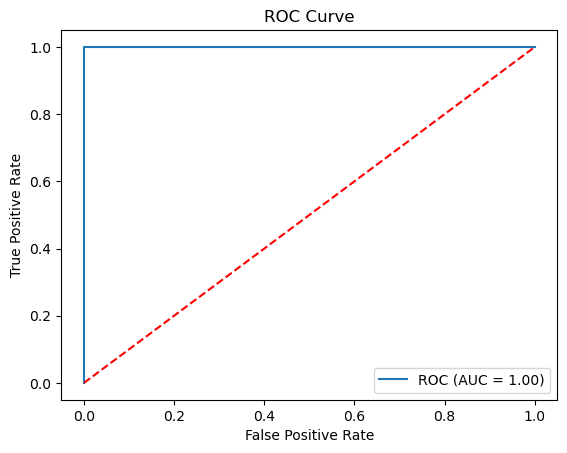

In [26]:
# Plot ROC curve and AUC score
rfe_score = roc_auc_score(Y_train, y_pred)
# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds= roc_curve(Y_train, rfe.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC (AUC = %0.2f)' % rfe_score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The ROC curve is shonwn above, and the AUC is calculated as 100%.

In [27]:
# Report the estimated parameters and p-values accordingly
X_train_new = X_train[cols]
logit_model_selected = sm.Logit(Y_train, X_train_new)
model_selected = logit_model_selected.fit(method = 'lbfgs')
print(model_selected.summary())

                           Logit Regression Results                           
Dep. Variable:          bending_label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            9
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        13:33:28   Log-Likelihood:            -3.4262e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.417e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
mean_5_2        1.5858    2.4e+04   6.62e-05      1.000   -4.69e+04    4.69e+04
median_5_2      1.5160   2.23e+04   6.78e-05      1.000   -4.38e+04    4.38e+04
mean_5_3        1.4098   1.57e+04   9.01e-05    

The summary of the logistic regression is displayed above. We can see that the p-value for all estimator is $1.000 > \alpha = 0.05$. Assume that we conduct hypothesis testing for all estimator we have. We would fail to reject the null hypothesis that $\beta_i = 0$. This means that the estimators here are statistically insignificant, which is due to perfect seperated of classes.

### v.
Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [28]:
# Get testing set
df_LR_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

# Define model input
X_test = df_LR_test.iloc[:, :-2]
Y_test = df_LR_test.iloc[:,-2:-1]

# Fit logistic model
model_test = LogisticRegression(solver='liblinear')
rfe = RFE(model_test, n_features_to_select=10)
rfe.fit(X_test, Y_test.values.ravel())
y_pred_test = rfe.predict(X_test)
print("Cross-validation score:", rfe.score(X_test, Y_test))

Cross-validation score: 1.0


The accuracy on the test set is the same as the accuracy score on the train set as previously computed.

### vi. 
Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes, the classes seem to be well-separeted as we can see we obtained p-value equals to 1 for the estimators.

### vii. 
From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

From the confusion matrices, we see that we have high true positive and low true negative. We have larger cost on the true positive side. Thus, we will build logistic regression model based on case-control sampling.

In [29]:
# Use SMOTE package to resample data
smote = SMOTE(random_state=2)
# Resample the data
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

parameters = {'C': np.linspace(1, 10, 10)}

# Refit the model
mod_lr = LogisticRegression()
gs= GridSearchCV(mod_lr, parameters, cv=5)
gs.fit(X_train_smote, Y_train_smote)

mod_lr = LogisticRegression(C = gs.best_params_.get('C'))
mod_lr.fit(X_train_smote, Y_train_smote)
y_train_pre = mod_lr.predict(X_train)

# Display confusion matrix
confusion_matrix_resampled = confusion_matrix(Y_train, y_train_pre)
print("CONFUSION MATRIX")
print(confusion_matrix_resampled)

CONFUSION MATRIX
[[60  0]
 [ 0  9]]


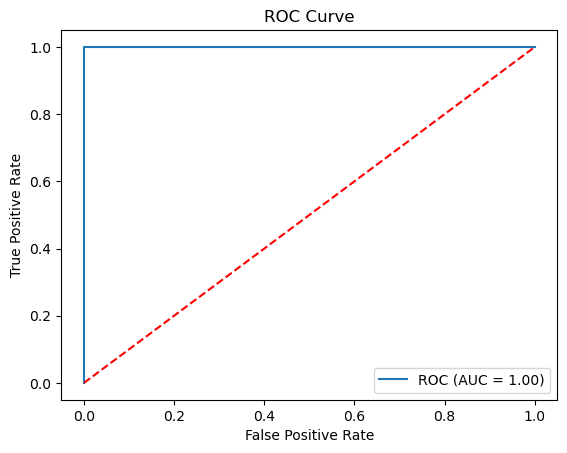

In [30]:
# Plot ROC curve and calculate AOC
rfe_score = roc_auc_score(Y_train, y_train_pre)
fpr, tpr, thresholds= roc_curve(Y_train, mod_lr.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC (AUC = %0.2f)' % rfe_score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The case-control sampling model confusion matrix, ROC, and AUC are shown above.

## (b) Binary Classification Using L1-penalized logistic regression

### i.
Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and $\lambda$, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for $\lambda$ automatically.

In [31]:
# Define the size of time series in training set
TimeSeries_size = [i for i in range(1, 21)]

# Save Logistics model evaluation result
plist = list()
score = list()

# Iterate through all size and train Logistics model
for l in TimeSeries_size:
    # Format column names
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    # Add bending_label and testing_label to column names
    column_name.extend(["bending_label", "testing_label"])
    
    important_feature = list()
    # Iterate through bending1 folder
    important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
    # Iterate through bending2 folder
    important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
    # Iterate through other folders in ARem
    for folder_name in other:
        important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))
        
    # Make dataframe for all information extracted
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    # Set column name accordingly
    df_important_feature.columns = column_name
    # Convert to numeric values
    # df_important_feature = df_important_feature.apply(pd.to_numeric)
    df_important_feature["bending_label"] = df_important_feature["bending_label"].astype('int')

    # Get training data
    df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:,-2:-1]
    
    # Preprocessing
    scalar = StandardScaler()
    X_train_fit = scalar.fit_transform(X_train)

    parameters = {'C': np.linspace(1, 10, 10) }
    
    # Fit LR model
    mod_lr = LogisticRegression()
    clf = GridSearchCV(mod_lr, parameters, cv=5)
    clf.fit(X_train_fit, Y_train)

    sel_ = SelectFromModel(LogisticRegression(C= (1/clf.best_params_.get('C')), penalty='l1', solver='liblinear'))
    sel_.fit(X_train_fit, Y_train)
    print("At l =", i)
    selected_feat = X_train.columns[(sel_.get_support())]
    print('Selected features: {}'.format(len(selected_feat)))
    print('C-value', clf.best_params_.get('C'))
    print('Best score:', clf.best_score_)
    plist.append(len(selected_feat))
    score.append(clf.best_score_)

At l = 1
Selected features: 7
C-value 1.0
Best score: 0.9274725274725275
At l = 2
Selected features: 6
C-value 2.0
Best score: 0.9428571428571428
At l = 3
Selected features: 6
C-value 1.0
Best score: 0.9131868131868132
At l = 4
Selected features: 8
C-value 1.0
Best score: 0.9274725274725275
At l = 5
Selected features: 9
C-value 1.0
Best score: 0.9131868131868132
At l = 6
Selected features: 9
C-value 1.0
Best score: 0.9131868131868132
At l = 7
Selected features: 11
C-value 1.0
Best score: 0.9274725274725275
At l = 8
Selected features: 13
C-value 1.0
Best score: 0.9131868131868132
At l = 9
Selected features: 13
C-value 1.0
Best score: 0.9131868131868132
At l = 10
Selected features: 6
C-value 4.0
Best score: 0.9131868131868132
At l = 11
Selected features: 10
C-value 2.0
Best score: 0.9131868131868132
At l = 12
Selected features: 7
C-value 1.0
Best score: 0.9131868131868132
At l = 13
Selected features: 7
C-value 1.0
Best score: 0.9131868131868132
At l = 14
Selected features: 9
C-value 1.0


### ii.
Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

In [32]:
# Display best model result
df_bestp = pd.DataFrame({"l": TimeSeries_size, "p-features": plist, "Score":score})
df_bestp.index = np.arange(1, 21)
# Sort dataframe based on CV-score and l
df_bestp = df_bestp.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

 l  p-features    Score
 2           6 0.942857
 1           7 0.927473
 4           8 0.927473
 7          11 0.927473
15          13 0.927473
16           7 0.927473
18          11 0.927473
 3           6 0.913187
 5           9 0.913187
 6           9 0.913187
 8          13 0.913187
 9          13 0.913187
10           6 0.913187
11          10 0.913187
12           7 0.913187
13           7 0.913187
14           9 0.913187
17          13 0.913187
19           8 0.913187
20           8 0.913187


We see that the model with $(l, p) = (2, 6)$ pair performs the best among all models. We will then display the p-values of this model.

In [33]:
l = 2
# Format column names
column_name = list()
for i in range(1, l+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(feature+"_"+str(series_name)+"_"+ str(i))
# Add bending_label and testing_label to column names
column_name.extend(["bending_label", "testing_label"])

important_feature = list()
# Iterate through bending1 folder
important_feature.extend(important_feature_extraction("bending1", 7, 2, l))
# Iterate through bending2 folder
important_feature.extend(important_feature_extraction("bending2", 6, 2, l))
# Iterate through other folders in ARem
for folder_name in other:
    important_feature.extend(important_feature_extraction(folder_name, 15, 3, l))

# Make dataframe for all information extracted
df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
# Set column name accordingly
df_important_feature.columns = column_name
# Convert to numeric values
df_important_feature = df_important_feature.apply(pd.to_numeric)
df_important_feature["bending_label"] = df_important_feature["bending_label"].astype('int')

# Get training data
df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

# Define model input
X_train = df_LR_train.iloc[:, :-2]
Y_train = df_LR_train.iloc[:,-2:-1]

In [35]:
# Declare Logistic Regression model
model_train = LogisticRegression(solver='liblinear')
# Train model based on value obtained above
rfe = RFE(model_train, n_features_to_select=5)
# Fit model on training data
rfe.fit(X_train, Y_train)
# Make prediction based on model above
y_pred = rfe.predict(X_train)
# Obtain columns selected
cols = list(X_train.columns[rfe.support_])

# Report the estimated parameters and p-values accordingly
X_train_new = X_train[cols]
logit_model_selected = sm.Logit(Y_train, X_train_new)
model_selected = logit_model_selected.fit(method = 'lbfgs')
print(model_selected.summary())

                           Logit Regression Results                           
Dep. Variable:          bending_label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       64
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.4842
Time:                        15:04:39   Log-Likelihood:                -13.782
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.360e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
mean_5_1        0.2785      0.125      2.231      0.026       0.034       0.523
mean_6_1        0.3229      2.262      0.143      0.886      -4.110       4.756
std dev_3_2    -0.3436      0.467     -0.736    

We see that the model with L1-penalized logistic regression performs better than the model we fit previously based on the p-values obtained. The previous model is harder to implement than the one with L1-penalied logistic regression.

## (c). Multi-class Classification (The Realistic Case)

### i.
Find the best $l$ in the same way as you found it in **2(b)i** to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [36]:
# Modify the function defined in HW3 to extract 3 time-domain features for 6 series in each instance
# Note that we also add L=number of partition to split the data
# Features: mean, median, and standard deviation
# class_label = 1 for bending1, class_label = 2 for bending2, class_label = 3 for cycling
# class_label = 4 for lying, class_label = 5 for sitting, class_label = 6 for standing
# class_label = 7 for walking, so 7 types of activities in total
# testing_label = 1 for testing data, testing_label = 0 for training data

def important_feature_extraction_multiclass(FolderName, num_csv, num_test, l):
    # Define path to locate csv files
    train_csv = list()
    test_csv = list()

    # Format training and testing file path
    for i in range(1, num_test+1):
        path = '../data/ARem/' + FolderName + "/dataset" + str(i) +".csv"
        test_csv.append(path)
    for i in range(num_test+1, num_csv+1):
        path = '../data/ARem/' + FolderName + "/dataset" + str(i) +".csv"
        train_csv.append(path)

    feature_extraction = list()  # Hold statistics for all file we read
    # Read testing csv file into dataframe
    for filename in test_csv:
        df = pd.read_csv(filename, names=csv_header, skiprows=5)
        df = df.drop("time", axis=1)  # Drop time column

        # Split dataframe into sub dataframe according to L = number of partition
        # df_split is a list of sub dataframe
        df_split = np.array_split(df, l)

        split_info = list()  # Initialize a list to hold information for the single dataframe, i.e. csv

        # For each sub dataframe, find mean, median, and std dev
        for df_sub in df_split:
            sub_df_info = list()  # Initialize a list to hold information for each sub dataframe
            for series_name in series:
                for feature in features:
                    # Obtain statistics in the order of mean, median and std dev
                    sub_df_info.append(df_sub.describe()[series_name][feature])

            split_info.extend(sub_df_info)  # Add dataframe into info list

        # Include class_label indicating activity type
        if FolderName == "bending1":
            split_info.append(str(1))
        elif FolderName == "bending2":
            split_info.append(str(2))
        elif FolderName == "cycling":
            split_info.append(str(3))
        elif FolderName == "lying":
            split_info.append(str(4))
        elif FolderName == "sitting":
            split_info.append(str(5))
        elif FolderName == "standing":
            split_info.append(str(6))
        elif FolderName == "walking":
            split_info.append(str(7))

        # Include label for testing
        split_info.append(str(1))

        # Concatenate statistics for all splits 
        df_concat_info = pd.DataFrame(split_info).transpose()
        feature_extraction.append(df_concat_info)
        
    # Read training csv file into dataframe
    for filename in train_csv:
        df = pd.read_csv(filename, names=csv_header, skiprows=5)
        df = df.drop("time", axis=1)  # Drop time column

        # Split dataframe into sub dataframe according to L = number of partition
        # df_split is a list of sub dataframe
        df_split = np.array_split(df, l)

        split_info = list()  # Initialize a list to hold information for the single dataframe, i.e. csv

        # For each sub dataframe, find mean, median, and std dev
        for df_sub in df_split:
            sub_df_info = list()  # Initialize a list to hold information for each sub dataframe
            for series_name in series:
                for feature in features:
                    # Obtain statistics in the order of mean, median and std dev
                    sub_df_info.append(df_sub.describe()[series_name][feature])

            split_info.extend(sub_df_info)  # Add dataframe into info list

        # Include class_label indicating activity type
        if FolderName == "bending1":
            split_info.append(str(1))
        elif FolderName == "bending2":
            split_info.append(str(2))
        elif FolderName == "cycling":
            split_info.append(str(3))
        elif FolderName == "lying":
            split_info.append(str(4))
        elif FolderName == "sitting":
            split_info.append(str(5))
        elif FolderName == "standing":
            split_info.append(str(6))
        elif FolderName == "walking":
            split_info.append(str(7))

        # Include label for training
        split_info.append(0)

        # Concatenate statistics for all splits 
        df_concat_info = pd.DataFrame(split_info).transpose()
        feature_extraction.append(df_concat_info)
    
    return feature_extraction

In [37]:
# Define the size of time series in training set
TimeSeries_size = [i for i in range(1, 21)]

# Save Logistics model evaluation result
plist = list()
score = list()

# Iterate through all size and train Logistics model
for l in TimeSeries_size:
    # Format column names
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    # Add bending_label and testing_label to column names
    column_name.extend(["class_label", "testing_label"])
    
    important_feature = list()
    # Iterate through bending1 folder
    important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, l))
    # Iterate through bending2 folder
    important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, l))
    # Iterate through other folders in ARem
    for folder_name in other:
        important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, l))
        
    # Make dataframe for all information extracted
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    # Set column name accordingly
    df_important_feature.columns = column_name
    # Convert to numeric values
    # df_important_feature = df_important_feature.apply(pd.to_numeric)
    df_important_feature["class_label"] = df_important_feature["class_label"].astype('int')
    df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

    # Get training data
    df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:,-2:-1]
    
    # Preprocessing
    scalar = StandardScaler()
    X_train_fit = scalar.fit_transform(X_train)

    parameters = {'C': np.linspace(1, 10, 10) }
    
    # Fit LR model
    mod_lr = LogisticRegression()
    clf = GridSearchCV(mod_lr, parameters, cv=5)
    clf.fit(X_train_fit, Y_train)

    sel_ = SelectFromModel(LogisticRegression(C=(1/clf.best_params_.get('C')), 
                                              multi_class='multinomial', 
                                              penalty='l1', 
                                              solver='saga'))
    sel_.fit(X_train_fit, Y_train)
    print("At l =", i)
    selected_feat = X_train.columns[(sel_.get_support())]
    print('Selected features: {}'.format(len(selected_feat)))
    print('C-value', clf.best_params_.get('C'))
    print('Best score:', clf.best_score_)
    plist.append(len(selected_feat))
    score.append(clf.best_score_)

At l = 1
Selected features: 14
C-value 1.0
Best score: 0.9428571428571428
At l = 2
Selected features: 25
C-value 2.0
Best score: 0.9
At l = 3
Selected features: 33
C-value 3.0
Best score: 0.8692307692307691
At l = 4
Selected features: 46
C-value 2.0
Best score: 0.8549450549450549
At l = 5
Selected features: 29
C-value 8.0
Best score: 0.8692307692307691
At l = 6
Selected features: 55
C-value 4.0
Best score: 0.8538461538461538
At l = 7
Selected features: 36
C-value 7.0
Best score: 0.8252747252747253
At l = 8
Selected features: 106
C-value 1.0
Best score: 0.8263736263736263
At l = 9
Selected features: 98
C-value 2.0
Best score: 0.8417582417582418
At l = 10
Selected features: 127
C-value 1.0
Best score: 0.8406593406593407
At l = 11
Selected features: 53
C-value 7.0
Best score: 0.7824175824175824
At l = 12
Selected features: 48
C-value 8.0
Best score: 0.798901098901099
At l = 13
Selected features: 100
C-value 4.0
Best score: 0.8406593406593406
At l = 14
Selected features: 182
C-value 1.0
Be

In [38]:
# Display best model result
df_bestp = pd.DataFrame({"l": TimeSeries_size, "p-features": plist, "Score":score})
df_bestp.index = np.arange(1, 21)
# Sort dataframe based on CV-score and l
df_bestp = df_bestp.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

 l  p-features    Score
 1          14 0.942857
 2          25 0.900000
 3          33 0.869231
 5          29 0.869231
 4          46 0.854945
 6          55 0.853846
 9          98 0.841758
10         127 0.840659
13         100 0.840659
15         194 0.839560
 8         106 0.826374
 7          36 0.825275
18         235 0.813187
14         182 0.812088
12          48 0.798901
19         192 0.783516
20         118 0.783516
11          53 0.782418
17         226 0.782418
16         202 0.768132


We see that the $(l, p) = (1, 14)$ gives us the best model.

In [39]:
# Train model with parameters we obtained above

l = 1
# Format column names
column_name = list()
for i in range(1, l+1):
    for series_name in series_formatname:
        for feature in features_formatname:
            column_name.append(feature+"_"+str(series_name)+"_"+ str(i))
# Add bending_label and testing_label to column names
column_name.extend(["class_label", "testing_label"])

important_feature = list()
# Iterate through bending1 folder
important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, l))
# Iterate through bending2 folder
important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, l))
# Iterate through other folders in ARem
for folder_name in other:
    important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, l))

# Make dataframe for all information extracted
df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
# Set column name accordingly
df_important_feature.columns = column_name
# Convert to numeric values
df_important_feature = df_important_feature.apply(pd.to_numeric)
df_important_feature["class_label"] = df_important_feature["class_label"].astype('int')
df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

# Get training data
df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

# Define model input
X_train = df_LR_train.iloc[:, :-2]
Y_train = df_LR_train.iloc[:,-2:-1]

In [40]:
# Declare Multiclass Logistic Regression model
model_train = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')
# Train model based on value obtained above
rfe = RFE(model_train, n_features_to_select=14)
# Fit model on training data
rfe.fit(X_train, Y_train)

# Obtain testing data
df_LR_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

# Define X_Test and Y_Test 
X_test = df_LR_test.iloc[:, :-2]
Y_test = df_LR_test.iloc[:,-2:-1]

# Find model score
model_score = rfe.score(X_test, Y_test)
# Report model error
print("Test error :", 1-model_score)

Test error : 0.21052631578947367


We find the test error for the multi-class logistic regression is 0.2105.

### ii. 
Repeat **2(c)i** using a Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.

In [41]:
# Naive Bayes' classifier - Gaussian

# Define the size of time series in training set
TimeSeries_size = [i for i in range(1, 21)]

# Save model evaluation result
score = list()

# Iterate through all size and train Naive Bayes' classifier
for l in TimeSeries_size:
    # Format column names
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    # Add bending_label and testing_label to column names
    column_name.extend(["class_label", "testing_label"])
    
    important_feature = list()
    # Iterate through bending1 folder
    important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, l))
    # Iterate through bending2 folder
    important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, l))
    # Iterate through other folders in ARem
    for folder_name in other:
        important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, l))
        
    # Make dataframe for all information extracted
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    # Set column name accordingly
    df_important_feature.columns = column_name
    # Convert to numeric values
    df_important_feature["class_label"] = df_important_feature["class_label"].astype('int')
    df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

    # Get training data
    df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:,-2:-1]
    
    # Get testing data
    df_LR_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

    # Define model prediction input
    X_test = df_LR_test.iloc[:, :-2]
    Y_test = df_LR_test.iloc[:,-2:-1]
    
    # Fit Naive Bayes' classifier
    Gau_clf = GaussianNB()
    Gau_clf.fit(X_train, Y_train)
    # Save model score
    score.append(Gau_clf.score(X_test, Y_test))
    print("At l =", l)
    print("Score: ", score[l-1])

At l = 1
Score:  0.8421052631578947
At l = 2
Score:  0.6842105263157895
At l = 3
Score:  0.8421052631578947
At l = 4
Score:  0.8421052631578947
At l = 5
Score:  0.8421052631578947
At l = 6
Score:  0.7894736842105263
At l = 7
Score:  0.631578947368421
At l = 8
Score:  0.7368421052631579
At l = 9
Score:  0.7368421052631579
At l = 10
Score:  0.7368421052631579
At l = 11
Score:  0.7368421052631579
At l = 12
Score:  0.631578947368421
At l = 13
Score:  0.631578947368421
At l = 14
Score:  0.8421052631578947
At l = 15
Score:  0.7894736842105263
At l = 16
Score:  0.7894736842105263
At l = 17
Score:  0.6842105263157895
At l = 18
Score:  0.631578947368421
At l = 19
Score:  0.7894736842105263
At l = 20
Score:  0.7368421052631579


In [42]:
# Display best l result by find the best score
df_bestp = pd.DataFrame({"l": TimeSeries_size, "Score":score})
df_bestp.index = np.arange(1, 21)
# Sort dataframe based on score
df_bestp = df_bestp.sort_values(by="Score", ascending=False)
print(df_bestp.to_string(index=False))

 l    Score
 1 0.842105
14 0.842105
 3 0.842105
 4 0.842105
 5 0.842105
 6 0.789474
19 0.789474
16 0.789474
15 0.789474
11 0.736842
10 0.736842
 9 0.736842
 8 0.736842
20 0.736842
 2 0.684211
17 0.684211
12 0.631579
13 0.631579
18 0.631579
 7 0.631579


In [45]:
# Naive Bayes' classifier - Multinomial

# Define the size of time series in training set
TimeSeries_size = [i for i in range(1, 21)]

# Save model evaluation result
score = list()

# Iterate through all size and train Naive Bayes' classifier
for l in TimeSeries_size:
    # Format column names
    column_name = list()
    for i in range(1, l+1):
        for series_name in series_formatname:
            for feature in features_formatname:
                column_name.append(feature+"_"+str(series_name)+"_"+ str(i))

    # Add bending_label and testing_label to column names
    column_name.extend(["class_label", "testing_label"])
    
    important_feature = list()
    # Iterate through bending1 folder
    important_feature.extend(important_feature_extraction_multiclass("bending1", 7, 2, l))
    # Iterate through bending2 folder
    important_feature.extend(important_feature_extraction_multiclass("bending2", 6, 2, l))
    # Iterate through other folders in ARem
    for folder_name in other:
        important_feature.extend(important_feature_extraction_multiclass(folder_name, 15, 3, l))
        
    # Make dataframe for all information extracted
    df_important_feature = pd.concat(important_feature, axis=0, ignore_index=True)
    # Set column name accordingly
    df_important_feature.columns = column_name
    # Convert to numeric values
    df_important_feature["class_label"] = df_important_feature["class_label"].astype('int')
    df_important_feature["testing_label"] = df_important_feature["testing_label"].astype('int')

    # Get training data
    df_LR_train = df_important_feature.loc[df_important_feature['testing_label'] == 0]

    # Define model input
    X_train = df_LR_train.iloc[:, :-2]
    Y_train = df_LR_train.iloc[:,-2:-1]
    
    # Get testing data
    df_LR_test = df_important_feature.loc[df_important_feature['testing_label'] == 1]

    # Define model prediction input
    X_test = df_LR_test.iloc[:, :-2]
    Y_test = df_LR_test.iloc[:,-2:-1]
    
    # Fit Naive Bayes' classifier
    Multi_clf = MultinomialNB()
    Multi_clf.fit(X_train, Y_train)
    # Save model score
    score.append(Multi_clf.score(X_test, Y_test))
    print("At l =", l)
    print("Score: ", score[l-1])

At l = 1
Score:  0.8421052631578947
At l = 2
Score:  0.8421052631578947
At l = 3
Score:  0.8947368421052632
At l = 4
Score:  0.8421052631578947
At l = 5
Score:  0.7894736842105263
At l = 6
Score:  0.7894736842105263
At l = 7
Score:  0.8421052631578947
At l = 8
Score:  0.8421052631578947
At l = 9
Score:  0.7894736842105263
At l = 10
Score:  0.8421052631578947
At l = 11
Score:  0.8947368421052632
At l = 12
Score:  0.8947368421052632
At l = 13
Score:  0.8421052631578947
At l = 14
Score:  0.8421052631578947
At l = 15
Score:  0.8947368421052632
At l = 16
Score:  0.8947368421052632
At l = 17
Score:  0.8421052631578947
At l = 18
Score:  0.8421052631578947
At l = 19
Score:  0.8421052631578947
At l = 20
Score:  0.8421052631578947


In [46]:
# Display best l result by find the best score
df_bestp = pd.DataFrame({"l": TimeSeries_size, "Score":score})
df_bestp.index = np.arange(1, 21)
# Sort dataframe based on score
df_bestp = df_bestp.sort_values(by="Score", ascending=False)
print(df_bestp.to_string(index=False))

 l    Score
11 0.894737
12 0.894737
 3 0.894737
16 0.894737
15 0.894737
19 0.842105
18 0.842105
17 0.842105
14 0.842105
13 0.842105
 1 0.842105
 2 0.842105
10 0.842105
 8 0.842105
 7 0.842105
 4 0.842105
20 0.842105
 9 0.789474
 6 0.789474
 5 0.789474


### iii. 
Which method is better for multi-class classification in this problem?

In the multi-class classification, we see that the Bayes' classifier with Multinomial priors obtain the best testing result.

# 3. ISLR, 4.8.3

We want to show that the Bayes classifier is not linear and further argue that it is quadratic.

We know the posterior probability of the Baye's classifier is given by

$$
p_k(x) = \frac{\pi_k \frac{1}{\sqrt{2 \pi} \sigma_k} \exp\big({-\frac{1}{2 \sigma_k^2} (x-\mu_k)^2}\big)}
        { \sum_{l=1}^{k}\pi_l \frac{1}{\sqrt{2 \pi} \sigma_l} \exp\big({-\frac{1}{2 \sigma_l^2} (x-\mu_l)^2}\big)}
$$

where we want to the maximum of a class. To do so, we see that we want to maximize the log function.

Then we have 

$$
\begin{align*}
\log{(p_k(x))}
    &= \log{(\pi_k)} - \log{(\sqrt{2\pi} \sigma_k)} -\frac{1}{2 \sigma_k^2}(x-\mu_k)^2 \\
    &= \log{(\pi_k)} - \log{(\sigma_k)} - \frac{\mu_k^2}{2\sigma_2^k} + \frac{x \mu_k^2}{\sigma_k^2} - \frac{x^2}{2\sigma_k^2}
\end{align*}
$$

We then see that the Bayes classifier is not linear. It is, indeed, quadratic.

# 4. ISLR, 4.8.7

We identify that $\pi_{YES} = 0.8$, which indicates that $\pi_{No} = 0.2$. Then we want to plug numbers into the probability function

$$
\begin{align*}
p_{yes}(4) 
    &= \frac{0.8 \exp\big({-\frac{1}{2 \cdot 36} (4 - 10)^2}\big)}
        {0.8 \exp\big({-\frac{1}{2 \cdot 36} (4 - 10)^2}\big) + 0.2 \exp\big({-\frac{1}{2 \cdot 36} (4 - 0)^2}\big)} \\
    &= 0.75
\end{align*}
$$

# Reference

[Features for time series classification](https://stats.stackexchange.com/questions/50807/features-for-time-series-classification#:~:text=Usually%20the%20features%20used%20to,than%20being%20features%20in%20themselves.)

[Import multiple CSV files into pandas and concatenate into one DataFrame](https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe)

[`scipy.stats.bootstrap`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html)

[`sklearn.feature_selection.RFECV`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

[`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[`sklearn.naive_bayes.GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

[SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

[Time series classification based on statistical features](https://jwcn-eurasipjournals.springeropen.com/articles/10.1186/s13638-020-1661-4)